In [17]:
import warnings
 
import pandas as pd
import numpy as np
warnings.filterwarnings('ignore')
def organize_data(raw_data):
    if isinstance(raw_data,pd.core.series.Series):
        return pd.DataFrame(raw_data)
    print("Enter 0 for xlsx. 1 for csv")
    choice = int(input())
    if choice:
        df =pd.DataFrame(pd.read_csv(raw_data)['Other'].dropna())
        df.columns = range(len(df.columns))
        return df
    else:
        raw_data = pd.read_excel(raw_data,header=None)    
    if len(raw_data.columns) > 1:
        print(f"Seems that you have more than one column {list(raw_data.columns)}... Press enter if you want to drop all except the 1st.")
        print(f"Write \'all\' if you want to work with all columns. Else, enter the columns you want to work with (E.g 0 1 2)")
        choice = input()
        if not choice:
            return raw_data.squeeze()
        elif choice=='all':
            columns = list(raw_data.columns)
            data = raw_data[0].squeeze()
        else:
            choice = list(map(int,choice.split()))
            columns = list(raw_data.columns)
            drop = [x for x in columns if x not in choice]
            raw_data = raw_data.drop(axis=1,columns=drop)
            raw_data.columns = range(raw_data.columns.size)
            columns = list(raw_data.columns)
            data = raw_data[0].squeeze()
        if len(columns) > 1:
            for column in columns[1:]:
                data = pd.concat([data,raw_data[column].squeeze()])
    return pd.DataFrame(data)        
 
def gen_raw_data(): #edit this file if you want personalized raw data
    return pd.DataFrame(pd.concat([pd.Series(np.random.standard_normal(800)),pd.Series(np.random.exponential(4,200))]))
 
 
def create_freq_dist_table(data, number_classes):
    min_data = data[0].min()
    min_data_ocurr = data[0].value_counts()[min_data]
    max_data = data[0].max()
    range_data = max_data - min_data
    class_width = float(range_data/number_classes)
    bins = np.arange(min_data,max_data+class_width,class_width)
    data['class'] = pd.cut(data[0],bins=bins)
    data = data.groupby("class")[0].count().to_frame(name="abs_freq")
    data.iloc[0]["abs_freq"] += min_data_ocurr
    data["rel_freq"] = data.abs_freq/data.abs_freq.sum()
    data["cum_abs_freq"] = data.abs_freq.cumsum()
    data["cum_rel_freq"] = data["rel_freq"].cumsum()
    data = data.reset_index()
    data['class_mark'] = data['class'].apply(lambda x: (x.left+x.right)/2)
    # cols = data.columns.tolist()    TODO
    # cols = cols[-1:] + cols[:-1]    TODO
    return data,bins
 
 
def generate_data(freq_table,k):
    gen_data = pd.Series(dtype='float64')
    n_data_bef = freq_table.iloc[-1]["cum_abs_freq"]
    intervals, freq_bef = freq_table["class"], freq_table["rel_freq"]
    for i in range(len(intervals)):
        data_numb = int(round(freq_bef.iloc[i]*k,0))
        low_bound = intervals.iloc[i].left
        high_bound = intervals.iloc[i].right
        gen_data = pd.concat([gen_data,pd.Series(np.random.uniform(low_bound,high_bound,data_numb))])
    return pd.DataFrame(gen_data)
 
def get_percentile(raw_data, syn_data):
    percentile_d = []
    percentile_s = []
    for i in range(5,995,5):
        percentile_d.append(raw_data.quantile(i/1000))
        percentile_s.append(syn_data.quantile(i/1000))
    return percentile_d, percentile_s
 
def data_from_table(table):
    media = round(sum(table.apply(lambda x:(x['rel_freq']*x['class_mark']),axis=1)),6)
    std = round(np.sqrt(sum(table.apply(lambda row:((row['class_mark']-media)**2)*row['abs_freq'],axis = 1))/table.iloc[-1,3]),6)
    std1 = np.sqrt(sum(table.apply(lambda row:((row['class_mark']-media)**2)*row['abs_freq'],axis = 1))/(table.iloc[-1,3]-1))
    asim = sum(table.apply(lambda row:((row['class_mark']-media)**3)*row['abs_freq'],axis = 1))/(table.iloc[-1,3]*(std1**3))
    kurt = (sum(table.apply(lambda row:((row['class_mark']-media)**4)*row['abs_freq'],axis = 1))/(table.iloc[-1,3]*(std1**4)))-3
    quantile_25 = quantile(25,table)
    quantile_50 = quantile(50,table)
    quantile_75 = quantile(75,table)
    min=table.iloc[0,0].left
    max=table.iloc[-1,0].right
    return pd.Series([media,std,min,quantile_25,quantile_50,quantile_75,max,asim,kurt])
 
def quantile(q, table):
    n = max(table['cum_abs_freq'])
    index = (q/100)*n
    condition = table['cum_abs_freq'] >= index
    row =  condition.idxmax()
    Li = table['class'].iloc[row].left
    len_interval = table['class'].iloc[row].length
    Ni = table['abs_freq'].iloc[row]
    j = index - table['cum_abs_freq'].iloc[row-1]
    return (Li + len_interval*(j/Ni))
 
def main(): 
    if (input("Enter if file, another key if generated raw data")== ""):
        print('Give me your file (csv or xlsx) and the number of classes. Remember to upload the file to this folder.')
        raw_data = input("File: ")
        raw_data = organize_data(raw_data)
    else:
        raw_data = gen_raw_data()
    number_classes = int(round(np.sqrt((len(raw_data))),0))
    freq_table, data_bins = create_freq_dist_table(raw_data,number_classes)
    synthetic = generate_data(freq_table,int(input("Number of synthetic data: ")))
    data_stats= raw_data.describe().iloc[1:].append([raw_data.skew()[0],raw_data.kurtosis()[0]]).reset_index()
    synt_stats = synthetic.describe().iloc[1:].append([synthetic.skew()[0],synthetic.kurtosis()[0]]).reset_index()
    syn_table, syn_bins = create_freq_dist_table(synthetic,number_classes)
    data_p, syn_p = get_percentile(raw_data,synthetic)
    statistics_from_table = data_from_table(freq_table)
    raw_data.columns = ['Histograma de Frecuencias de Datos Crudos', 'class']
    synthetic.columns = ['Histograma de Frecuencias de Datos Simulados', 'class']
    
    return freq_table, data_bins, data_stats, synt_stats,synthetic,raw_data, syn_table, syn_bins,data_p, syn_p, statistics_from_table
 
 
 
 
table, data_bins, data_stats, synt_stats, synthetic_data, raw_data, syn_table, syn_bins, data_p, syn_p, statistics_table= main()
 
 
d = pd.DataFrame({'': ['Media','Standard Deviation','Minimum','25%','50%','75%','Maximum','Skew','Kurtosis'],"raw_data":data_stats[0], "synthetic_data":synt_stats[0], 'freq_table_data':statistics_table})

In [19]:
d

,,raw_data,synthetic_data,freq_table_data
0,Media,0.815294,0.594242,0.811958
1,Standard Deviation,2.512764,1.914036,2.535507
2,Minimum,-3.114701,-2.893536,-3.115000
3,25%,-0.487389,-0.576713,-0.518235
4,50%,0.341853,0.287685,0.332605
5,75%,1.276980,1.289209,1.351408
6,Maximum,22.806025,8.988761,23.616000
7,Skew,3.412193,1.674045,3.334861
8,Kurtosis,18.081247,4.367415,17.342436


(array([[<AxesSubplot: title={'center': 'Histograma de Frecuencias de Datos Crudos'}>]],
       dtype=object),
 array([[<AxesSubplot: title={'center': 'Histograma de Frecuencias de Datos Simulados'}>]],
       dtype=object))

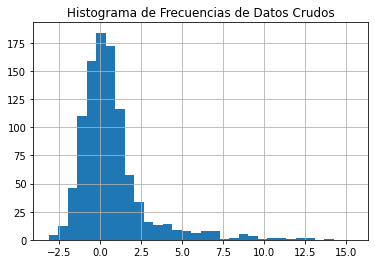

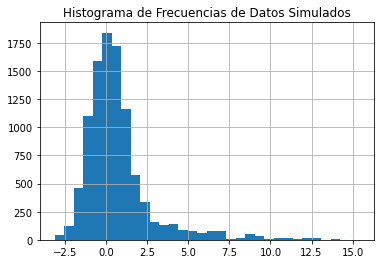

In [9]:
raw_data.hist(bins=data_bins), synthetic_data.hist(bins=data_bins) 

Text(0, 0.5, 'Datos Crudos')

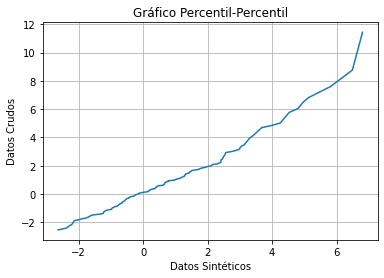

In [21]:
import matplotlib.pyplot as plt
plt.plot(syn_p, data_p)
plt.plot()
plt.grid()
plt.title("Gráfico Percentil-Percentil")
plt.xlabel("Datos Sintéticos")
plt.ylabel("Datos Crudos")

In [11]:
type(data_stats)
d = {"raw_data": data_stats[0], "synthetic_data":synt_stats[0]}
pd.DataFrame(d)
raw_data.kurtosis(), synthetic_data.kurtosis()

(Histograma de Frecuencias de Datos Crudos    9.462631
 dtype: float64,
 Histograma de Frecuencias de Datos Simulados    8.257303
 dtype: float64)